In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
from sqlalchemy import Column, Integer, String, Float

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
#find column names for tables
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
print("table: 'mesurement' info: ")
for c in measurement_columns:
    print(c['name'], c["type"])

print("------------------------------------------")
station_columns = inspector.get_columns('station')
print("table: 'station' info: ")
for c in station_columns:
    print(c['name'], c["type"])

table: 'mesurement' info: 
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------------------------------------
table: 'station' info: 
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
#find the latest date
ordered_measurement = session.query(Measurement.prcp, Measurement.date).order_by(Measurement.date.desc())
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [15]:
#Query to retrieve the last 12 months of precipitation data
precipitation_list = []
precipitation_data = ordered_measurement.filter(Measurement.date >= '2016-08-23' )
for i in precipitation_data:
    precipitation_list.append(i)
print(precipitation_list[:10])

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation_list, columns=['Percipitation', 'Date'])
df = df.set_index('Date')
df.head(10)

# Use Pandas Plotting with Matplotlib to plot the data
#df.plot(kind ='bar', y='Percipitation')

[(0.0, '2017-08-23'), (0.0, '2017-08-23'), (0.08, '2017-08-23'), (0.45, '2017-08-23'), (0.0, '2017-08-22'), (0.0, '2017-08-22'), (0.5, '2017-08-22'), (0.0, '2017-08-21'), (0.02, '2017-08-21'), (None, '2017-08-21')]


,Percipitation
Date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00
2017-08-22,0.00
2017-08-22,0.50
2017-08-21,0.00
2017-08-21,0.02


![precipitation](Images/precipitation.png)

In [76]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary = df.describe()

![describe](Images/describe.png)

In [77]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [54]:
#Finding most active stations using query session
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [55]:
#Finding the most active stations using pandas
station_list = []
ordered_stations = session.query(Measurement.station, Measurement.date)
for i in ordered_stations: 
    station_list.append(i)
station_df = pd.DataFrame(station_list, columns=['Station', 'Count'])
station_df = station_df.groupby(["Station"]).count()
station_df = station_df.sort_values(by=['Count'], ascending=False)
station_df

,Count
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [19]:
# calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature most active station.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == "USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

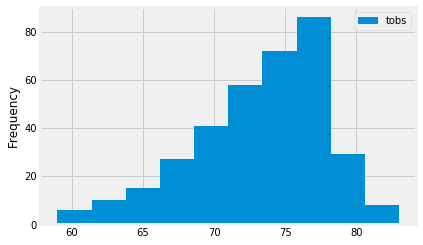

In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_list = []
highest_temp = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= '2016-08-23')
temp_df = pd.DataFrame(highest_temp, columns=['tobs'])
temp_df.plot.hist();


In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


[(65.0, 69.66666666666667, 75.0)]


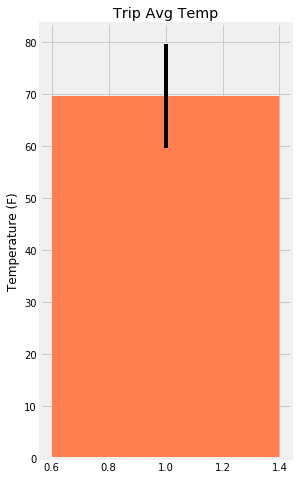

In [42]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
results = calc_temps('2011-02-28', '2011-02-28')
print(results)
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
peak = results[0][2] - results[0][0]
bar = ax.bar(1, results[0][1], yerr = peak, color = "coral")
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
fig.show()


In [53]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Station.name,
              Station.latitude, Station.longitude, 
              Station.elevation, func.count(Measurement.prcp)).\
group_by(Measurement.station, Station.name,
              Station.latitude, Station.longitude, 
              Station.elevation).order_by(func.count(Measurement.prcp).desc()).all()

[('USC00519281',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  2772),
 ('USC00519281', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2772),
 ('USC00519281',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  2772),
 ('USC00519281',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2772),
 ('USC00519281', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2772),
 ('USC00519281',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  2772),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2772),
 ('USC00519281', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 2772),
 ('USC00519281',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2772),
 ('USC00513117',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  2696),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2696),
 ('USC00513117',
  'KUALOA RANCH HEAD